## Fetching Data from NBA API

In [16]:
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import leaguedashteamstats
import pandas as pd
import logging

# Configure logging
logging.basicConfig(filename='data_processing.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Dictionary of team abbreviations to IDs
team_dict = {
    'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739,
    'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742,
    'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745,
    'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748,
    'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751,
    'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754,
    'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
    'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760,
    'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763,
    'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766
}

player_id = 201939  # Steph Curry's player ID
season = '2024-25'
season_type_all_star='Regular Season'

# Fetch player game log
game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star=season_type_all_star)
df = game_log.get_data_frames()[0]

# Add home/away status and opponent ID
df['Home'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
df['Opponent'] = df['MATCHUP'].apply(lambda x: x.split()[-1])
df['opponent_id'] = df['Opponent'].map(team_dict)

# Fetch defensive stats vs. position
stats = leaguedashteamstats.LeagueDashTeamStats(
    season=season,
    season_type_all_star=season_type_all_star,
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)
defense_stats_df = stats.get_data_frames()[0]

# Merge player game logs with defensive stats using suffixes
df = df.merge(defense_stats_df, left_on='opponent_id', right_on='TEAM_ID', how='left', suffixes=('_player', '_team'))

# Save to CSV
df.to_csv('steph_curry_game_stats_{}.csv'.format(season), index=False)

# Combine CSVs
df_23 = pd.read_csv('steph_curry_game_stats_2023-24.csv')
df_24 = pd.read_csv('steph_curry_game_stats_2024-25.csv')
combined_df = pd.concat([df_24, df_23], ignore_index=True)

# Ensure data is sorted by game date (ascending order)
combined_df['GAME_DATE'] = pd.to_datetime(combined_df['GAME_DATE'], format='%b %d, %Y')
combined_df.sort_values('GAME_DATE', inplace=True)

# Calculate rolling averages for points (rolling window of 5 games)
combined_df['PTS_Last_5'] = combined_df['PTS'].rolling(window=5).mean()

# Calculate rest days
combined_df['Rest_Days'] = combined_df['GAME_DATE'].diff().dt.days
combined_df['Rest_Days'] = combined_df['Rest_Days'].fillna(0)


# Select relevant features and target
features = [
    'MIN_player',  # Player minutes
    'FGA',         # Field goal attempts
    'FG_PCT',      # Field goal percent
    'FG3A',        # 3-Point attempts
    'FG3_PCT',     # 3-Point percent
    'FTM',         # Free throws made
    'Home',        # Home/Away indicator
    'Rest_Days',   # Days of rest before the game
    'PTS_Last_5',# Rolling average of points
    'opponent_id', # Opponent team id
    'OPP_PTS',     # Opponent defense vs position
    'OPP_FG_PCT',  # Opponent field goal percent
    'OPP_REB',     # Opponent rebounds vs position
    'OPP_AST'      # Opponent assists vs position
]
target = 'PTS'

# Drop rows with missing values for numerical features and target
combined_df.dropna(subset=features + [target], inplace=True)

# Log dataset state
logging.info(f"Dataset shape after feature engineering: {combined_df.shape}")
logging.info(f"Columns: {list(combined_df.columns)}")

# Save to CSV
combined_df.to_csv('steph_curry_combined_game_stats.csv', index=False)
print("CSV file saved successfully!")


CSV file saved successfully!


## Obtain opponent stats vs position

In [72]:
stats = leaguedashteamstats.LeagueDashTeamStats(
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)

defense_stats_df = stats.get_data_frames()[0]

# Save to CSV
defense_stats_df.to_csv('defensive_stats_guard_2024_25.csv', index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


## Training Model and Evaluation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the CSV data
data = pd.read_csv('steph_curry_combined_game_stats.csv')

# Define features and target variable
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Print the actual and predicted values
print("Actual values in test set:", y_test.values)
print("Predicted values:", predictions)


Mean Squared Error: 38.00589271714421
Actual values in test set: [15 21 27 27 37 26 35 17 23 26 18 25 23 46 22 16 24]
Predicted values: [12.65034635 21.47878362 28.59264323 27.52036947 36.39524337 26.39845089
 34.63551333 -7.15177179 22.21242177 26.34314756 21.26776976 22.93952557
 28.79298258 45.84485462 23.87923168 15.28123829 23.46652321]


## Visualisation

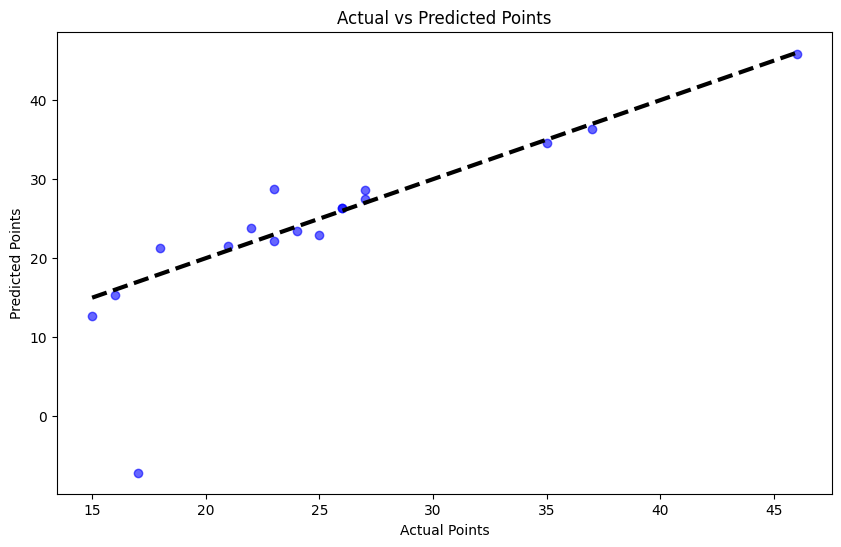

In [20]:
import matplotlib.pyplot as plt
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()


## Feature Selection - correlation matrix

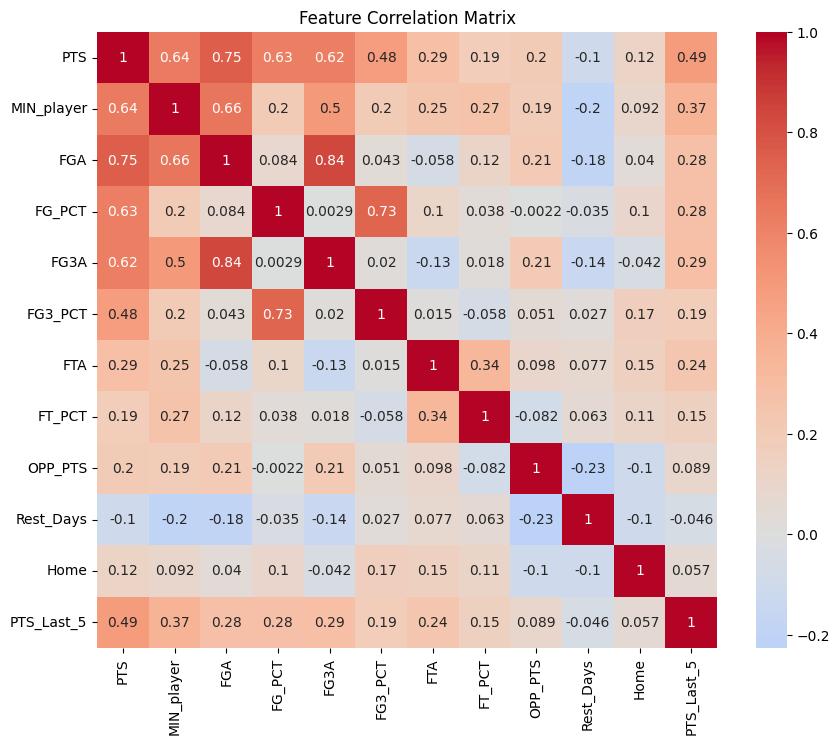

In [32]:
import seaborn as sns
# Select relevant features for scoring prediction
features_to_check = [
    'PTS',  # Target variable
    'MIN_player',  # Minutes played
    'FGA',  # Field goal attempts
    'FG_PCT',  # Field goal percentage
    'FG3A',  # 3-point attempts
    'FG3_PCT',  # 3-point percentage
    'FTA',  # Free throw attempts
    'FT_PCT',  # Free throw percentage
    'OPP_PTS',  # Opponent points
    'Rest_Days',  # Days of rest
    'Home',  # Home/Away
    'PTS_Last_5'  # Last 5 games scoring average
]

correlation_matrix = combined_df[features_to_check].corr()

#create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## Prediction for Future Games

In [75]:
# Example mock data for an upcoming game with the Home feature
mock_data = {
    'MIN_player': [30],
    'FGM': [8],
    'FTM': [5],
    'REB': [3],
    'AST': [4],
    'STL': [0],
    'BLK': [0],
    'Home': [1],  # Example: playing at home
    'opponent_id': [1610612740],
    'OPP_PTS': [52.4],
    'OPP_REB': [19.8],
    'OPP_AST': [12.3],

}
mock_df = pd.DataFrame(mock_data)

# Predict points for the next game
prediction = model.predict(mock_df)
print("Predicted Points for the next game:", prediction[0])


Predicted Points for the next game: 27.041220605373383
